# American Census

In [3]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate

import matplotlib.pyplot as plt

## Global config

In [55]:
# Data config
path_to_csv = "adult.csv"


## Load data

In [56]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")


## Helpers

## Data exploration

### Question 1

In [5]:
"There are 11 features and 1 target variable - the salary. A good observation is that the target data is not evenly split: 12360 out of 16281 samples are negative. Given that, using solely accuracy, recall, precision or specificity will not give us a good metric for our model. The problem with it is that it equalizes the missclasification. Usually the costs are not the same and having in mind it is not specified, it is better to go for AUC/ROC Curve. AUC/ROC Curve is really useful instrument which can give us good visualization of both cases of missclasification. As long as we do not need exact probability of an entry belonging to target variable 0 or 1, we are good to go."

### Question 2

In [6]:
"Using gender and race can lead to really biased algorithm. There are already existing cases where people's CVs were discarded based only on the gender. These 2 features should not affect our algorithm as they should not play a role in the salary a person receives. We can use them for statistics, but not for decision-making. Given that we believe that gender and race should not be included."

## Data exploration

### Question 1

In [57]:
# X_train = X_train.dropna(subset=["occupation"])
check = X_train.loc[X_train['occupation'].isnull()]
to_drop = list(check.index.values)
X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)
no_hours_X_train = X_train.dropna(subset=["education-num"])
means = no_hours_X_train.groupby('education')['education-num'].mean()

means_dict = means.to_dict()

X_train['education-num'] = X_train.apply(
    lambda row: means_dict[row['education']] if np.isnan(row['education-num']) else row['education-num'],
    axis=1
)


"There are missing values in 4 columns: education-num(240), workclass(936), occupation(1181) and native-country(300)."
"'education-num': most likely user forgot to give input, we estimate (take the average) based on type of education. So if a person has type of education 'Masters', we set education-num as the average of all the people who did 'Masters'."
"'workclass': empty because there is no occupation, below 50,000$ for sure."
"'occupation': most likely the person is unemployed, below 50,000$ for sure."
"'native-country': most likely user did not want to give input, we leave it like that."

"'native-country': most likely user did not want to give input, we leave it like that."

### Question 2

In [58]:
pd.set_option('display.max_rows', 10)

workclass = X_train['workclass'].unique()
workclass = {k: v for v, k in enumerate(workclass)}

education = X_train['education'].unique()
education = {k: v for v, k in enumerate(education)}

marital = X_train['marital-status'].unique()
marital = {k: v for v, k in enumerate(marital)}

occupation = X_train['occupation'].unique()
occupation = {k: v for v, k in enumerate(occupation)}

relationship = X_train['relationship'].unique()
relationship = {k: v for v, k in enumerate(relationship)}

country = X_train['native-country'].unique()
country = {k: v for v, k in enumerate(country)}

X_train['workclass'].replace(workclass, inplace=True)
X_train['education'].replace(education, inplace=True)
X_train['marital-status'].replace(marital, inplace=True)
X_train['occupation'].replace(occupation, inplace=True)
X_train['relationship'].replace(relationship, inplace=True)
X_train['native-country'].replace(country, inplace=True)

workclass = X_test['workclass'].unique()
workclass = {k: v for v, k in enumerate(workclass)}

education = X_test['education'].unique()
education = {k: v for v, k in enumerate(education)}

marital = X_test['marital-status'].unique()
marital = {k: v for v, k in enumerate(marital)}

occupation = X_test['occupation'].unique()
occupation = {k: v for v, k in enumerate(occupation)}

relationship = X_test['relationship'].unique()
relationship = {k: v for v, k in enumerate(relationship)}

country = X_test['native-country'].unique()
country = {k: v for v, k in enumerate(country)}

X_test['workclass'].replace(workclass, inplace=True)
X_test['education'].replace(education, inplace=True)
X_test['marital-status'].replace(marital, inplace=True)
X_test['occupation'].replace(occupation, inplace=True)
X_test['relationship'].replace(relationship, inplace=True)
X_test['native-country'].replace(country, inplace=True)


"The features that were transformed are 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'. All the unique values for each parameter are extracted and a dictionary is created with structure like {'unique_value_1': 0}. Then the values are replaced with the corresponding index. This way the solution is scalable."

"The features that were transformed are 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'. All the unique values for each parameter are extracted and a dictionary is created with structure like {'unique_value_1': 0}. Then the values are replaced with the corresponding index. This way the solution is scalable."

### Question 3

In [59]:
print(X_train)
X_train = X_train.drop(["race", "sex"], axis=1)
X_test = X_test.drop(["race", "sex"], axis=1)
print(X_train)
"As discussed in data exploration step - dropping 'sex' and 'race' as features should be done, as they should not influence the salary of a person."

       age  education-num  hours-per-week  workclass  education  \
0       30            9.0              40          0          0   
2       44           12.0              50          0          1   
3       53           10.0              50          0          2   
4       41           10.0              40          1          2   
5       50           14.0              50          0          3   
...    ...            ...             ...        ...        ...   
16275   31           11.0              30          0          6   
16276   37           13.0              40          4          4   
16277   45           14.0              40          4          3   
16278   32            9.0              40          0          0   
16279   58            7.0              50          0          9   

       marital-status  occupation  relationship                 race      sex  \
0                   0           0             0   Asian-Pac-Islander   Female   
2                   1           1

"As discussed in data exploration step - dropping 'sex' and 'race' as features should be done, as they should not influence the salary of a person."

## Experiments

### Question 1

In [7]:
"We will use cross-validate to verify the score of each algorithm. We will go through all of them and plot the algorithms' score and time they take as well, in order to pick the one which suits our needs. Moreover, we will use Excel table to keep track of the hyper-parameters tuning and check how the different adjustments influence the outcome of the algorithm. This will help us for not running same experiments twice and have a clearer vision of the direction in which we go."

       age  education-num  hours-per-week  workclass  education  \
10593   28           10.0              60          0          2   
6428    76            6.0              12          0         13   
2332    21            9.0              45          0          0   
950     45           13.0              35          2          4   
432     27            9.0              40          0          0   
...    ...            ...             ...        ...        ...   
16258   38           11.0              40          0          6   
2124    21            9.0              40          0          0   
11260   43           13.0              40          0          4   
15013   32           10.0              50          2          2   
9692    20            9.0              20          0          0   

       marital-status  occupation  relationship  race  sex  native-country  
10593               1           2             2     2    0               0  
6428                2           0        

### Question 2

In [9]:
# gnb = GaussianNB()
# gnb.fit(trainX, trainY)
# print(gnb.predict(testX))

models = {
    "GaussianNB" : GaussianNB(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighboursClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVC" : SVC(C=10, kernel="poly", random_state=42),
    "LogisticRegression": LogisticRegression(C=10, penalty = "none", random_state=42)
}

scores = {}
times = {}
cv=10
for name, model in models.items():
    cross_val = cross_validate(model, X_train, y_train, cv=cv)
    score = cross_val['test_score']
    time = np.add(cross_val['fit_time'], cross_val['score_time'])
    # print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    scores[name] = score
    times[name] = time

colors = ['b', 'g', 'r', 'y', 'k', 'w', 'c', 'm']
for (model, color) in zip(scores, colors):
    plt.plot(range(1, cv+1), scores[model], label=model, marker='o', color=color)
    mean = [scores[model].mean() for i in range(cv)]
    plt.plot(range(1, cv+1), mean, linestyle="--", color=color)

plt.xlabel('fold') 
plt.ylabel('score') 
plt.title("US-Census k-folds")
plt.legend() 
plt.show()

for model in scores:
    plt.plot(times[model], scores[model], 'o', label=model)
plt.xlabel('time in seconds') 
plt.ylabel('score') 
plt.title("US-Census Time")
plt.legend() 

plt.xscale('log')

plt.show()

"Тhere are 2 plots shown. On the first one we can observe the fold number on the x-axis and test score on the y-axis. For each algorithm we can see its score for each fold and a mean line as well. Observing exact score for fold doesn't matter that much, what matters more is to see the bias that the algorithm has compared to the mean. In the second plot we can observe the time (fit + score) for each fold and choose the algorithm suits us in terms of score/time. We can see that SVC and Logistic Regression have the highest score, however, SVC is much slower. This is most probably because those 2 algorithms are specifically designed for binary classification."


KeyboardInterrupt: 

### Question 3

In [ ]:
from sklearn.model_selection import GridSearchCV
# models = {
#     "GaussianNB" : GaussianNB(),
#     "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
#     "KNeighboursClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
#     "SVC" : SVC(C=10, kernel="poly", random_state=42),
#     "LogisticRegression": LogisticRegression(C=10, penalty = "none", random_state=42)
# }

# Logistic Regression
LogisticRegression_params = { 
    'C': [1, 2, 5],
    'penalty': ['none', 'l1', 'l2', 'elasticnet']
    }

# SVC
SVC_params = { 
    'C': [80, 100, 120],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
    
# Decision Tree
DecisionTreeClassifier_params = {
    'max_depth': range(8, 15),
    'min_samples_leaf': range(15, 24)
}

# K-Nearest Neighbours
KNeighboursClassifier_params = {
    'n_neighbors': [23, 24, 25, 26],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=LogisticRegression_params)
grid_res = grid_search.fit(X_train, y_train)
best_params_lr = grid_res.best_params_
best_score_lr = grid_res.best_score_
print(best_params_lr)
print(best_score_lr)

grid_search = GridSearchCV(estimator=SVC(), param_grid=SVC_params)
grid_res = grid_search.fit(X_train, y_train)
best_params_svc = grid_res.best_params_
best_score_svc = grid_res.best_score_
print(best_params_svc)
print(best_score_svc)

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=DecisionTreeClassifier_params)
grid_res = grid_search.fit(X_train, y_train)
best_params_dtc = grid_res.best_params_
best_score_dtc = grid_res.best_score_
print(best_params_dtc)
print(best_score_dtc)

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=KNeighboursClassifier_params)
grid_res = grid_search.fit(X_train, y_train)
best_params_kn = grid_res.best_params_
best_score_kn = grid_res.best_score_
print(best_params_kn)
print(best_score_kn)

"We have used GridSearchCV and first we put 3 random values per parameter for each algorithm and then adjusted them for lower/higher ones depending if the outcome was the min/max until we found the optimal hyperparameters. We have tried to test different edge values as well (for example C=0.00001 and C=200) in order to check if we are not in a local maximum."
"Logistic Regression: best penalty and C parameters are 2 and 'l2' respectively, with score: 0.813100123061669. Penalty and C are related with overfitting and regulation of the parameters."
"SVC: best kernel and C parameters are 'rbf' and 100 respectively, with score: 0.8173387310828331. The default parameter 'rbf' creates a good enough hyperplane. While the correction of C has to be higher."
"Decision Tree Classifier: best max_depth and min_samples_leaf are 11 and 20 respectively, with score: 0.8255513535686788. Not having 'max_depth' results in worse result, as the tree was overfitting before, thus pruning is needed. 'min_samples_leaf' is a 20, which increases the confidence when reaching leaf."
"K-Neighbors Classifier: best n_neighbors and weights are 24 and 'uniform' respectively, with score: 0.8083318672688865."


### Question 4

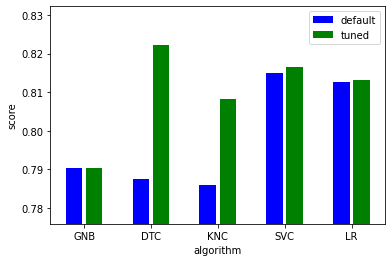

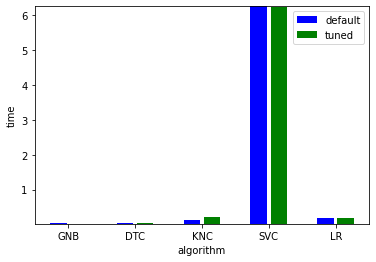

In [38]:
models = {
    "GaussianNB" : GaussianNB(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighboursClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVC" : SVC(C=10, kernel="poly", random_state=42),
    "LogisticRegression": LogisticRegression(C=10, penalty = "none", random_state=42)
}

models_tuned = {
    "GaussianNB" : GaussianNB(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=11, min_samples_leaf=20, random_state=42),
    "KNeighboursClassifier": KNeighborsClassifier(n_neighbors=24, weights="uniform"),
    "SVC" : SVC(C=100, kernel="rbf", random_state=42),
    "LogisticRegression": LogisticRegression(C=2, penalty = "l2", random_state=42)
}

scores = {}
times = {}
cv=10
for name, model in models.items():
    cross_val = cross_validate(model, X_train, y_train, cv=cv)
    score = cross_val['test_score']
    time = np.add(cross_val['fit_time'], cross_val['score_time'])
    # print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    scores[name] = score.mean()
    times[name] = time.mean()

scores_tuned = {}
times_tuned = {}
for name, model in models_tuned.items():
    cross_val = cross_validate(model, X_train, y_train, cv=cv)
    score = cross_val['test_score']
    time = np.add(cross_val['fit_time'], cross_val['score_time'])
    # print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    scores_tuned[name] = score.mean()
    times_tuned[name] = time.mean()

short_names = []
for name in models.keys():
    short_names.append(''.join([c for c in name if c.isupper()]))

X = np.arange(len(models))
low = min(scores.values()) - 0.01
high = max(scores_tuned.values()) + 0.01
plt.ylim(low, high)
plt.bar(X - 0.15, scores.values(), color = 'b', width = 0.25, label="default")
plt.bar(X + 0.15, scores_tuned.values(), color = 'g', width = 0.25, label="tuned")
plt.legend() 
plt.xticks(range(len(models)), short_names)
plt.xlabel('algorithm')  
plt.ylabel('score') 
plt.show()

"The plot shows the avarage score of 10 folds for each algorithm before and after being tuned. We can clearly see that the Decision Tree Classifier and the K-Nearest Neighbours CLassifier benefited the most from the tuning. SVC and Linear Regression got better score but just by slightly bit, which is negligible. Gaussian Naive Bayes is the same, as no tuning was done on it. After the tuning DTC is clearly the best algorithm to choose, not only that, but from previous tests we know that the time it takes is also one of the best."

### Question 5

In [62]:
classifier = DecisionTreeClassifier(max_depth=11, min_samples_leaf=20, random_state=42)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)

[0 0 0 ... 0 0 0]
